# MODELO CENTRALIZADO CON TODOS LOS DATOS

## IMPORTAR LIBRERÍAS

In [15]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import random

## SEMILLA POR REPRODUCIBILIDAD

In [ ]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

## PREPROCESO Y DIVISIÓN DE LOS DATOS

In [16]:
folder_path = r"/home/alkain/Escritorio/Github_Repositorios/Microgrid/TrainTestSplit"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def load_and_preprocess(files):
    df_list = []
    for file in files:
        file_path = os.path.join(folder_path, file)
        df = pd.read_csv(file_path, parse_dates=["Time Stamp (local standard time) yyyy-mm-ddThh:mm:ss"])
        df = df.drop(columns='Time Stamp (local standard time) yyyy-mm-ddThh:mm:ss')
        
        df_sampled = df.groupby('source', group_keys=False).apply(lambda x: x.sample(frac=1, random_state=42))
        df_list.append(df_sampled)
    
    full_df = pd.concat(df_list, ignore_index=True)
    
    full_df = pd.get_dummies(full_df, columns=['source'], prefix='src')
    
    return full_df

train_files = [f for f in os.listdir(folder_path) if f.endswith('.csv') and "train" in f]
test_files = [f for f in os.listdir(folder_path) if f.endswith('.csv') and "test" in f]

train_df = load_and_preprocess(train_files)
test_df = load_and_preprocess(test_files)

train_cols = train_df.columns
test_df = test_df.reindex(columns=train_cols).fillna(0)

X_train = train_df.drop(columns=['Pmp (W)']).values.astype(np.float32)
X_test = test_df.drop(columns=['Pmp (W)']).values.astype(np.float32)
y_train = train_df['Pmp (W)'].values.astype(np.float32)
y_test = test_df['Pmp (W)'].values.astype(np.float32)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train_tensor = torch.tensor(X_train).to(device)
y_train_tensor = torch.tensor(y_train).unsqueeze(1).to(device)
X_test_tensor = torch.tensor(X_test).to(device)
y_test_tensor = torch.tensor(y_test).unsqueeze(1).to(device)

/tmp/ipykernel_60016/3108539907.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df.groupby('source', group_keys=False).apply(lambda x: x.sample(frac=1, random_state=42))
/tmp/ipykernel_60016/3108539907.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df.groupby('source', group_keys=False).apply(lambda x: x.sample(frac=1, random_state=42))
/tmp/ipykernel_60016/3108539907.py

## DEFINICIÓN DEL MODELO Y SUS CAPAS

In [17]:
class EnhancedDNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.4),
            
            nn.Linear(256, 128),
            nn.ReLU(),
            
            nn.Linear(128, 64),
            nn.ReLU(),
            
            nn.Linear(64, 1)
        )
        
    def forward(self, x):
        return self.model(x)

## INICIALIZACIÓN DEL MODELO Y DE LOS HIPERPARÁMETROS

In [18]:
input_dim = X_train.shape[1]
model = EnhancedDNN(input_dim).to(device)

batch_size = 512
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, verbose=True)
criterion = nn.MSELoss()

epochs = 200
best_loss = np.inf
patience = 12
counter = 0
train_losses = []

/home/alkain/miniconda3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


## ENTRENAMIENTO DEL MODELO

In [19]:
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        outputs = model(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * xb.size(0)
    
    avg_loss = running_loss / len(train_loader.dataset)
    train_losses.append(avg_loss)
    scheduler.step(avg_loss)
    
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")
    
    if avg_loss < best_loss:
        best_loss = avg_loss
        counter = 0
        torch.save(model.state_dict(), "best_model_all_data.pth")
    else:
        counter += 1
        if counter >= patience:
            print(f"⏹️ Early stopping at epoch {epoch+1}")
            break

model.load_state_dict(torch.load("best_model_all_data.pth"))

Epoch [1/200], Loss: 302.5762
Epoch [2/200], Loss: 44.5671
Epoch [3/200], Loss: 36.5880
Epoch [4/200], Loss: 31.6158
Epoch [5/200], Loss: 28.8073
Epoch [6/200], Loss: 27.2098
Epoch [7/200], Loss: 25.7148
Epoch [8/200], Loss: 24.4054
Epoch [9/200], Loss: 23.8468
Epoch [10/200], Loss: 23.0725
Epoch [11/200], Loss: 22.7004
Epoch [12/200], Loss: 21.6043
Epoch [13/200], Loss: 21.3037
Epoch [14/200], Loss: 20.2338
Epoch [15/200], Loss: 20.2520
Epoch [16/200], Loss: 20.0320
Epoch [17/200], Loss: 19.3654
Epoch [18/200], Loss: 19.1247
Epoch [19/200], Loss: 18.3705
Epoch [20/200], Loss: 18.2020
Epoch [21/200], Loss: 17.7106
Epoch [22/200], Loss: 17.5164
Epoch [23/200], Loss: 17.3522
Epoch [24/200], Loss: 16.7062
Epoch [25/200], Loss: 15.9834
Epoch [26/200], Loss: 16.0287
Epoch [27/200], Loss: 15.9501
Epoch [28/200], Loss: 15.2736
Epoch [29/200], Loss: 15.2491
Epoch [30/200], Loss: 14.9881
Epoch [31/200], Loss: 14.4747
Epoch [32/200], Loss: 14.3536
Epoch [33/200], Loss: 14.4800
Epoch [34/200], Lo

<All keys matched successfully>

## EVALUACIÓN DEL MODELO
Métricas:
* MSE
* MAE
* R^2


📊 Test MSE: 17.3997
📏 Test MAE: 2.3205
📈 Test R2: 0.9878
MAE para Cocoa_CIGS39017.csv: 2.75
MAE para Cocoa_CIGS8-001.csv: 2.49
MAE para Cocoa_CdTe75638.csv: 2.26
MAE para Cocoa_HIT05667.csv: 6.84
MAE para Cocoa_aSiMicro03036.csv: 3.31
MAE para Cocoa_aSiTandem72-46.csv: 0.94
MAE para Cocoa_aSiTriple28324.csv: 2.11
MAE para Cocoa_mSi0166.csv: 1.09
MAE para Cocoa_mSi0188.csv: 1.07
MAE para Cocoa_mSi460A8.csv: 2.88
MAE para Cocoa_xSi12922.csv: 3.11
MAE para Eugene_CIGS39017.csv: 2.20
MAE para Eugene_CIGS8-001.csv: 1.58
MAE para Eugene_CdTe75638.csv: 1.60
MAE para Eugene_HIT05667.csv: 4.85
MAE para Eugene_aSiMicro03036.csv: 2.20
MAE para Eugene_aSiTandem72-46.csv: 0.70
MAE para Eugene_aSiTriple28324.csv: 1.45
MAE para Eugene_mSi0166.csv: 0.84
MAE para Eugene_mSi0188.csv: 0.83
MAE para Eugene_mSi460A8.csv: 2.24
MAE para Eugene_xSi12922.csv: 2.34
MAE para Golden_CIGS1-001.csv: 3.09
MAE para Golden_CIGS39013.csv: 4.85
MAE para Golden_CdTe75669.csv: 2.34
MAE para Golden_HIT05662.csv: 7.42
MAE 

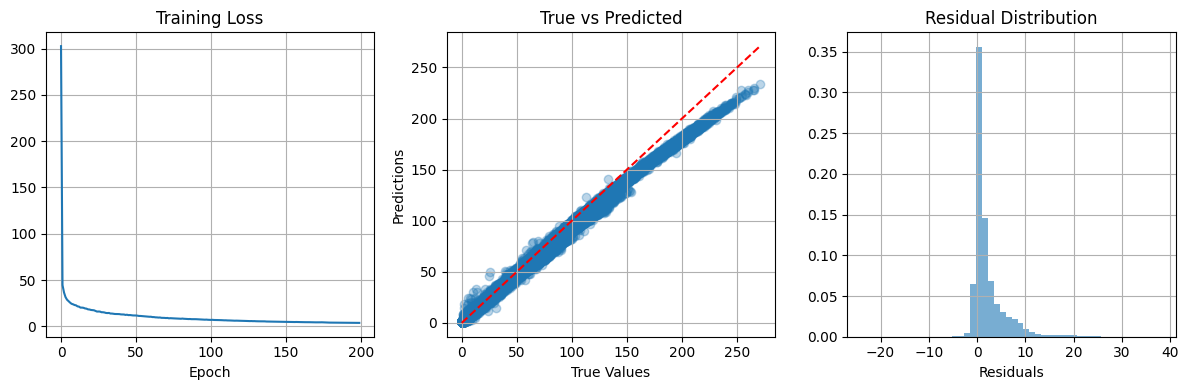

In [20]:
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor).cpu().numpy()
    y_test_np = y_test_tensor.cpu().numpy()
    
    mse = mean_squared_error(y_test_np, y_pred)
    mae = mean_absolute_error(y_test_np, y_pred)
    r2 = r2_score(y_test_np, y_pred)
    
    print(f"\n📊 Test MSE: {mse:.4f}")
    print(f"📏 Test MAE: {mae:.4f}")
    print(f"📈 Test R2: {r2:.4f}")
    
    test_df['pred'] = y_pred
    for col in test_df.filter(regex='^src_').columns:
        if test_df[col].sum() > 0: 
            source_name = col.replace('src_', '')
            subset = test_df[test_df[col] == 1]
            if not subset.empty:
                source_mae = mean_absolute_error(subset['Pmp (W)'], subset['pred'])
                print(f"MAE para {source_name}: {source_mae:.2f}")

plt.figure(figsize=(12, 4))

plt.subplot(131)
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.grid(True)

plt.subplot(132)
plt.scatter(y_test_np, y_pred, alpha=0.3)
plt.plot([0, y_test_np.max()], [0, y_test_np.max()], 'r--')
plt.title('True vs Predicted')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)

plt.subplot(133)
residuals = y_test_np - y_pred
plt.hist(residuals, bins=50, density=True, alpha=0.6)
plt.title('Residual Distribution')
plt.xlabel('Residuals')
plt.grid(True)

plt.tight_layout()
plt.show()